# Table of content
- **Introduction**
- **Model building, training and testing**

    - *Model building*
    - *Model training*
    - *Model testing*
- **Results**
    - *Accuracy*
    - *Confusion matrix*
    - *ROC curve*
    - *Loss curve*
    - *Classification report*

- **Conclusion**

# Introduction 
This project is about creating an algorithm that would predict the detection of lung cancer based on CT scans. The algorithm would also predict what type of cancer is within the patient and the size of the tumor if applied.

In [1]:
# Read the stored dataframe for categorical data
%store -r df_sick_lungs

In [1]:
# Import the necessary modules
# If you get a ModuleNotFoundError, use %pip install {module} to install the module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydicom as dicom
from pathlib import Path
import time
from zipfile import ZipFile 
import cv2
from tqdm import tqdm
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, recall_score, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xmltodict
import functions_project
from sklearn.preprocessing import LabelBinarizer

Functions import succesfull


# Model building, training and testing
In this chapter, the model will be build and trained before it will be tested among the test data.


In [104]:
# Split the data for the categorical classification using train_test_split
x_cat = np.array([np.array(val) for val in df_sick_lungs.image_pixels])
y_cat = pd.get_dummies(df_sick_lungs.cancer_type, prefix_sep='_')

# Split the data into a train and test set
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(x_cat, y_cat, test_size = 0.2, random_state = 42)

# Create the Dataset object to make it ready for the Neural Network
train_ds_cat = Dataset.from_tensor_slices((X_train_cat, y_train_cat))
test_ds_cat = Dataset.from_tensor_slices((X_test_cat, y_test_cat))

## Model building

In [120]:
# Set input parameters for categorical classification
model_name_categorical = "CNN_model_classification"
input_shape_categorical = (512, 512)
filters_categorical = [512, 256]
metrics_categorical = ['accuracy']
loss_categorical = 'categorical_crossentropy'
monitor_cat = 'val_accuracy'

optimizer_categorical = 'adam'
lr_categorical = 0.01

epochs_categorical = 50
batch_size_categorical = 12
steps_per_epcoh_categorical = 8
patience_categorical = 10

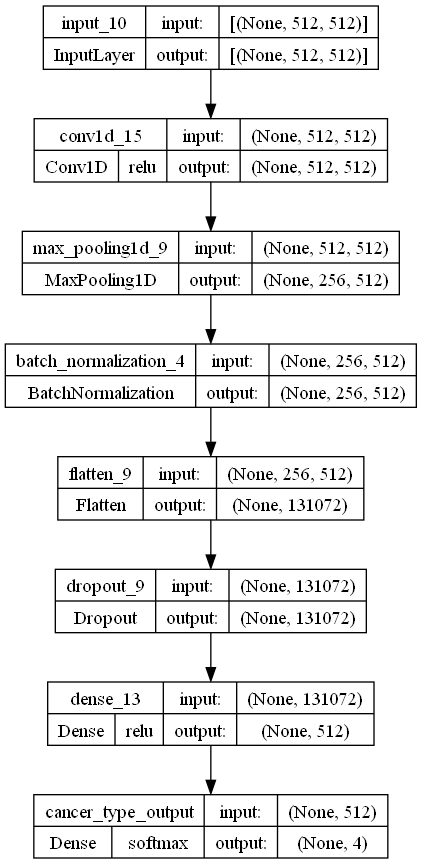

In [121]:
# Instantiate the categorical model
model_categorical = functions_project.create_categorical_model(model_name_categorical, inputShape = input_shape_categorical, filters = filters_categorical)

# Plot the model using the plot_model function
plot_model(model_categorical, model_name_categorical + ".png", show_shapes=True, show_layer_activations = True)

## Model training

In [122]:
# Train on the categorical model
hist_cat = functions_project.train_model(model_categorical, metrics_categorical, loss_categorical, optimizer_categorical, monitor_cat, train_ds_cat, test_ds_cat, 
                   epochs_categorical, batch_size_categorical, steps_per_epcoh_categorical, patience_categorical)

Epoch 1/50
8/8 [==============================] - 34s 4s/step - loss: 18903.2480 - accuracy: 0.2604 - val_loss: 1199.4863 - val_accuracy: 0.4240
Epoch 2/50
8/8 [==============================] - 27s 4s/step - loss: 1431.3839 - accuracy: 0.3021 - val_loss: 661.3510 - val_accuracy: 0.3929
Epoch 3/50
8/8 [==============================] - 30s 4s/step - loss: 637.4241 - accuracy: 0.3854 - val_loss: 422.0633 - val_accuracy: 0.3896
Epoch 4/50
8/8 [==============================] - 30s 4s/step - loss: 287.7932 - accuracy: 0.3646 - val_loss: 141.0105 - val_accuracy: 0.4104
Epoch 5/50
8/8 [==============================] - 31s 4s/step - loss: 101.7821 - accuracy: 0.3750 - val_loss: 85.0887 - val_accuracy: 0.4442
Epoch 6/50
8/8 [==============================] - 33s 5s/step - loss: 128.3740 - accuracy: 0.4167 - val_loss: 48.7748 - val_accuracy: 0.4727
Epoch 7/50
8/8 [==============================] - 32s 4s/step - loss: 43.3387 - accuracy: 0.4896 - val_loss: 52.3306 - val_accuracy: 0.4156
Epoch 

## Model testing

In [123]:
# Precict for the categorical data
pred_nn_cat = np.round(model_categorical.predict(test_ds_cat.batch(32)),0)

# Retrieve the predicted value based on index
categorical_test_labels = pd.DataFrame(y_test_cat.values).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred_nn_cat).idxmax(axis=1)

49/49 [==============================] - 21s 401ms/step


# Results
In this chapter, the results will be shown. For this, we'll look into the following:
- The True Negative Rate for detecting the lung cancer
- The Mean Absolute Error (MAE) for the size of the tumor
- Accuracy for the type of cancer and the corresponding confidence score.

## Results categorical Neural Network
In this paragraph, the results of the Categorical Neural Network will be shown. This is for detecting the type of cancer to the patient.

### Accuracy

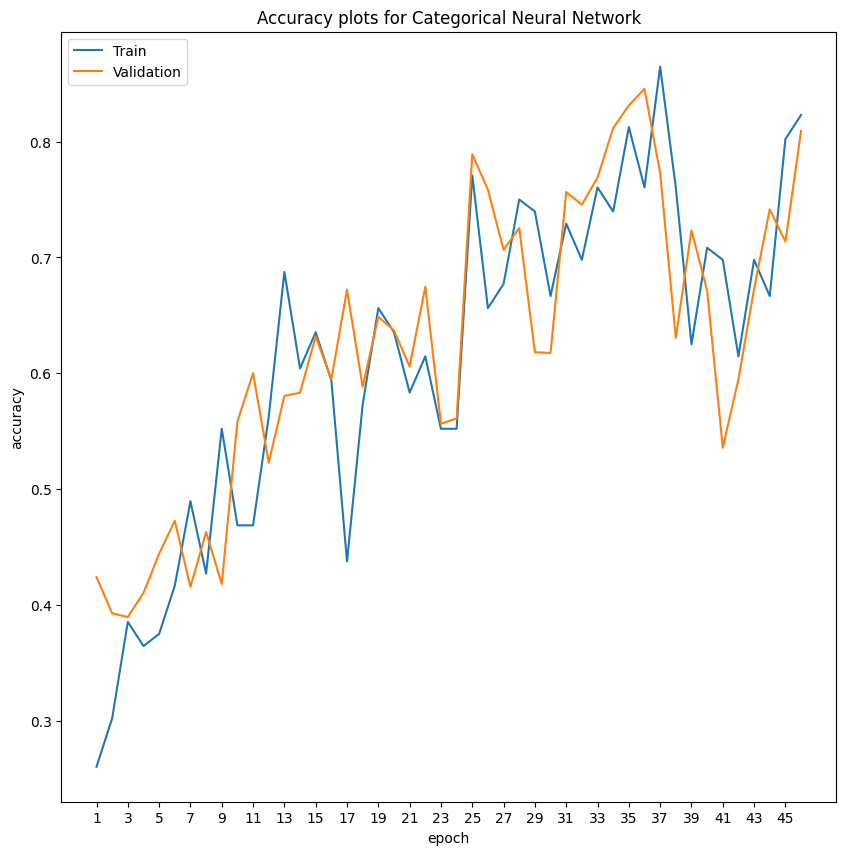

In [124]:
# Set parameters for accuracy plot for the categorical predictions
y_acc_cat = hist_cat.history['accuracy']
y_val_acc_cat = hist_cat.history['val_accuracy']
title_cat = "Accuracy plots for Categorical Neural Network"
ylabel = "accuracy"
figsize_cat = (10, 10)

# Summarize the historday for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_acc_cat, y_val_acc_cat, title_cat, ylabel, figsize_cat)

In [126]:
acc = accuracy_score(y_test_cat, pred_nn_cat)

print(f"Accuracy score of Categorical Neural Network: {acc:.2f}")

Accuracy score of Categorical Neural Network: 0.81


### Loss plots

### Confusion matrix

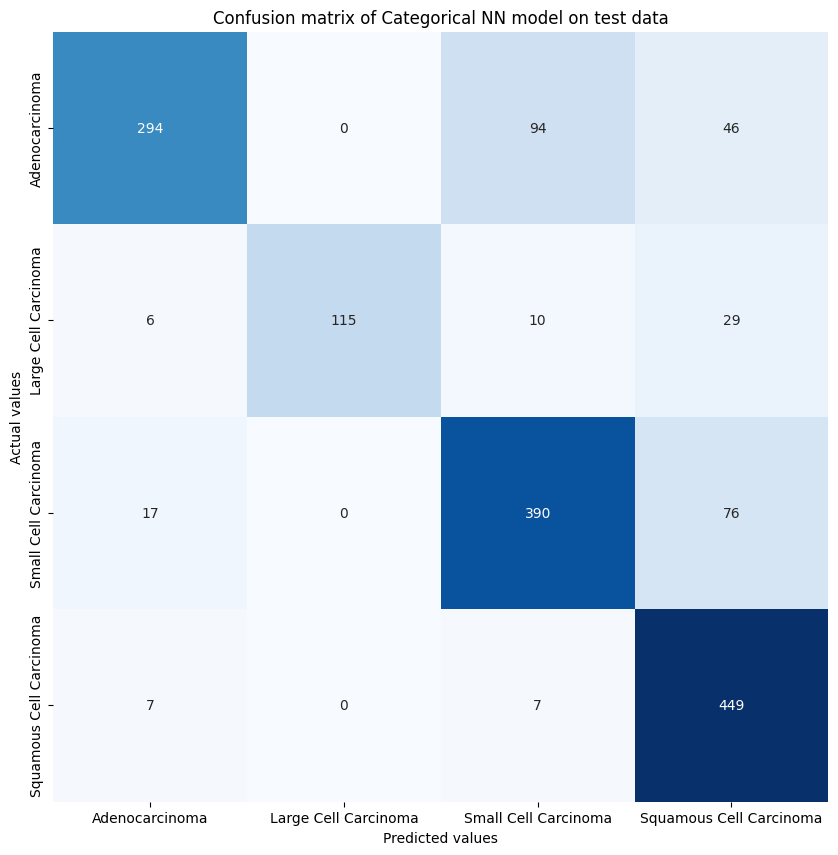

In [125]:
labels_categorical_nn = ["Adenocarcinoma", "Large Cell Carcinoma", "Small Cell Carcinoma", "Squamous Cell Carcinoma"]
title_cat = "Confusion matrix of Categorical NN model on test data"
figsize_cat = (10, 10)

# Display the confusion matrix of the categorical predictions
functions_project.plot_confusion_matrix(categorical_preds, categorical_test_labels, labels_categorical_nn, title_cat, figsize_cat)

### ROC curve

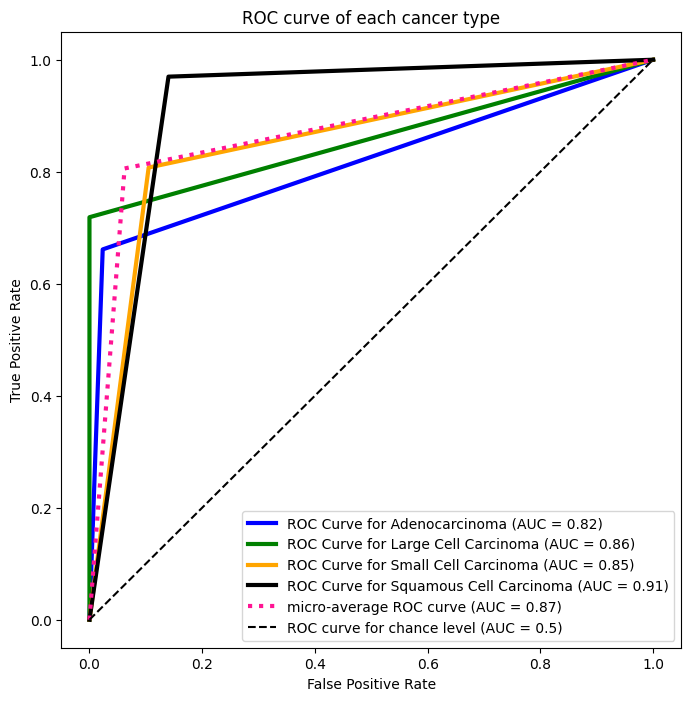

In [128]:
# Use a labelbianrizer to binarize the targets
label_binarizer = LabelBinarizer().fit(y_train_cat)
y_onehot_test = label_binarizer.transform(y_test_cat)
fpr_cat, tpr_cat, _ = roc_curve(y_onehot_test.ravel(), pred_nn_cat.ravel())
auc_micro = roc_auc_score(y_test_cat, pred_nn_cat, multi_class = "ovr", average = "micro")

# Set parameters
colours = ["blue", "green", "orange", "black"]

fig, ax = plt.subplots(figsize=(8, 8))

# Loop through each column for the cancer type data
for i in range(y_test_cat.shape[1]):
    # Set the data
    true = y_test_cat.values[:, i]
    pred = pred_nn_cat[:, i]
    auc = roc_auc_score(true, pred)
    name = f"ROC Curve for {y_test_cat.columns[i]}"

    # Create the ROC curve
    RocCurveDisplay.from_predictions(true, pred, color = colours[i], ax = ax, name = name, linewidth = 3)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve of each cancer type")


# Add the micro-averaged OvR to the independent outcomes
plt.plot(fpr_cat, tpr_cat, label=f"micro-average ROC curve (AUC = {auc_micro:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth = 3)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")

plt.legend()
# Display the outcomes
plt.show()
    

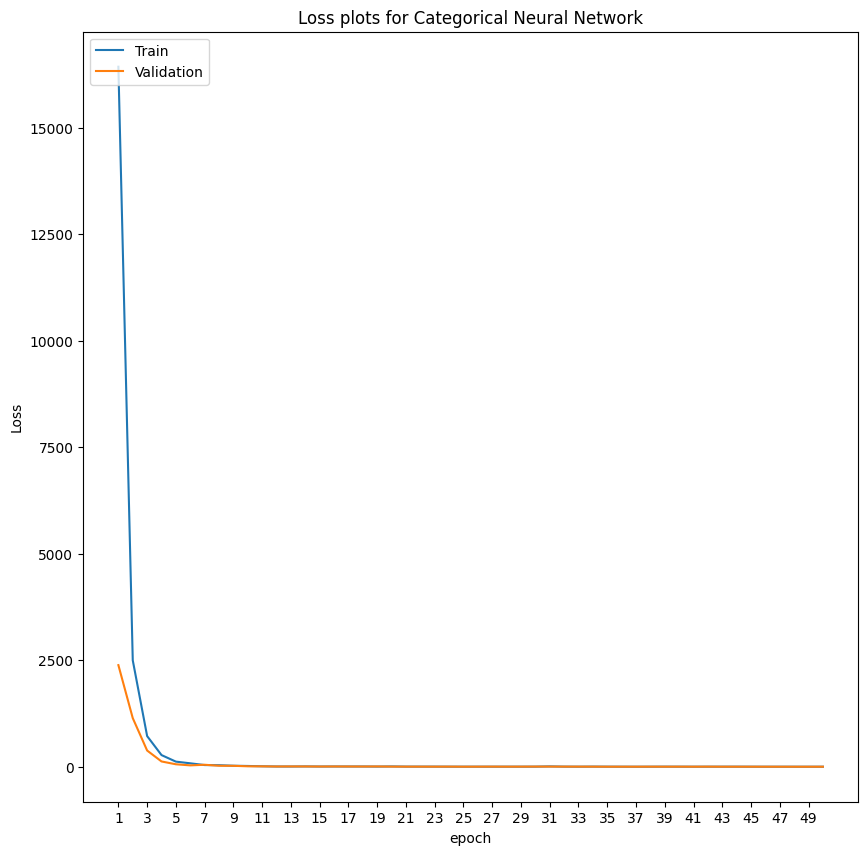

In [96]:
# Set parameters for loss plot for the categorical predictions
y_loss_cat = hist_cat.history['loss']
y_val_loss_cat = hist_cat.history['val_loss']
title_cat_loss = "Loss plots for Categorical Neural Network"
ylabel = "Loss"
figsize_cat = (10, 10)

# Summarize the historday for accuracy using the plot_accuracy function
functions_project.plot_accuracy(y_loss_cat, y_val_loss_cat, title_cat_loss, ylabel, figsize_cat)

### Classification report

In [127]:
# Get the classification report
class_rep_cat = classification_report(y_test_cat, pred_nn_cat, target_names = labels_categorical_nn)

print(class_rep_cat)

                         precision    recall  f1-score   support

         Adenocarcinoma       0.92      0.66      0.77       434
   Large Cell Carcinoma       1.00      0.72      0.84       160
   Small Cell Carcinoma       0.78      0.81      0.79       483
Squamous Cell Carcinoma       0.75      0.97      0.84       463

              micro avg       0.81      0.81      0.81      1540
              macro avg       0.86      0.79      0.81      1540
           weighted avg       0.83      0.81      0.81      1540
            samples avg       0.81      0.81      0.81      1540



c:\Users\ardejong\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion
Based on the results of the Neural Networks, we can conclude the following things:
- The recall score (a.k.a. True Negative Rate) for the binary predictions is 1.00. Although that is an amazing score, it could be less when the size of the data involved is larger. Nonetheless, it is expected that the results would still be very good.
- The accuracy score for the binary is 0.61. That is an ok score, but it is not the target we want to meet, which is 0.80. 
- For the regression model, we wanted to look at the Mean Absolute Error. It is quite difficult to estimate what a good MAE would be, but we can see from the graph that the MAE is not improving a lot after it has been run. Therefore, we can conclude that the model is not sufficient yet. 